In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

# Models we will use
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

# to get estimates of the model results
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# plots
from matplotlib import pyplot as plt

## Upload the data

In [5]:
df = pd.read_csv('../resources/premier-league_matches_merged.csv')[380:]
df

,Game ID,Wk,Day,Date,Time,Home,xG Home,G Home,Away,xG Away,...,Home Avg Goals For,Away Avg Goals For,Home Avg Goals Against,Away Avg Goals Against,Home Matches Played,Away Matches Played,Home Points/Match,Away Points/Match,Home Cumulative Points,Away Cumulative Points
380,0,1,Sat,12/09/2020,12:30,Fulham,0.1,0,Arsenal,1.9,...,0.00,1.47,0.00,1.26,0,38,0.00,1.47,0,56
381,1,1,Sat,12/09/2020,15:00,Crystal Palace,1.1,1,Southampton,0.9,...,0.82,1.34,1.32,1.58,38,38,1.13,1.37,43,52
382,2,1,Sat,12/09/2020,17:30,Liverpool,2.7,4,Leeds United,0.3,...,2.24,0.00,0.87,0.00,38,0,2.61,0.00,99,0
383,3,1,Sat,12/09/2020,20:00,West Ham,1.0,0,Newcastle Utd,1.6,...,1.29,1.00,1.63,1.53,38,38,1.03,1.16,39,44
384,4,1,Sun,13/09/2020,14:00,West Brom,0.4,0,Leicester City,2.8,...,0.00,1.76,0.00,1.08,0,38,0.00,1.63,0,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,418,38,Sun,19/05/2024,16:00,Brentford,1.1,2,Newcastle Utd,3.4,...,1.44,2.24,1.48,1.50,113,189,1.27,1.41,144,266
1896,419,38,Sun,19/05/2024,16:00,Chelsea,1.1,2,Bournemouth,2.2,...,1.78,1.32,1.68,1.70,189,113,1.65,1.07,311,121
1897,420,38,Sun,19/05/2024,16:00,Crystal Palace,2.5,5,Aston Villa,0.9,...,1.42,1.92,1.50,1.28,189,189,1.20,1.40,226,264
1898,421,38,Sun,19/05/2024,16:00,Liverpool,4.5,2,Wolves,0.5,...,2.24,1.26,1.20,1.72,189,189,2.15,1.28,406,242


Adding season column

In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Function to determine the season
def get_season(date):
    year = date.year
    month = date.month
    if month >= 8:  # From August onwards, it is the new season
        return year
    else:
        return year - 1
        
df['Season'] = df['Date'].apply(get_season)
df

,Game ID,Wk,Day,Date,Time,Home,xG Home,G Home,Away,xG Away,...,Away Avg Goals For,Home Avg Goals Against,Away Avg Goals Against,Home Matches Played,Away Matches Played,Home Points/Match,Away Points/Match,Home Cumulative Points,Away Cumulative Points,Season
380,0,1,Sat,2020-09-12,12:30,Fulham,0.1,0,Arsenal,1.9,...,1.47,0.00,1.26,0,38,0.00,1.47,0,56,2020
381,1,1,Sat,2020-09-12,15:00,Crystal Palace,1.1,1,Southampton,0.9,...,1.34,1.32,1.58,38,38,1.13,1.37,43,52,2020
382,2,1,Sat,2020-09-12,17:30,Liverpool,2.7,4,Leeds United,0.3,...,0.00,0.87,0.00,38,0,2.61,0.00,99,0,2020
383,3,1,Sat,2020-09-12,20:00,West Ham,1.0,0,Newcastle Utd,1.6,...,1.00,1.63,1.53,38,38,1.03,1.16,39,44,2020
384,4,1,Sun,2020-09-13,14:00,West Brom,0.4,0,Leicester City,2.8,...,1.76,0.00,1.08,0,38,0.00,1.63,0,62,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,418,38,Sun,2024-05-19,16:00,Brentford,1.1,2,Newcastle Utd,3.4,...,2.24,1.48,1.50,113,189,1.27,1.41,144,266,2023
1896,419,38,Sun,2024-05-19,16:00,Chelsea,1.1,2,Bournemouth,2.2,...,1.32,1.68,1.70,189,113,1.65,1.07,311,121,2023
1897,420,38,Sun,2024-05-19,16:00,Crystal Palace,2.5,5,Aston Villa,0.9,...,1.92,1.50,1.28,189,189,1.20,1.40,226,264,2023
1898,421,38,Sun,2024-05-19,16:00,Liverpool,4.5,2,Wolves,0.5,...,1.26,1.20,1.72,189,189,2.15,1.28,406,242,2023


In [11]:
df.columns

Index(['Game ID', 'Wk', 'Day', 'Date', 'Time', 'Home', 'xG Home', 'G Home',
       'Away', 'xG Away', 'G Away', 'Score', 'Home Avg Players Score',
       'Away Avg Players Score', 'Home Points', 'Away Points',
       'Home Avg Points', 'Away Avg Points', 'Home Avg Goals For',
       'Away Avg Goals For', 'Home Avg Goals Against',
       'Away Avg Goals Against', 'Home Matches Played', 'Away Matches Played',
       'Home Points/Match', 'Away Points/Match', 'Home Cumulative Points',
       'Away Cumulative Points', 'Season'],
      dtype='object')

In [13]:
df['Score'].value_counts()

Score
 1    666
-1    514
 0    340
Name: count, dtype: int64

 ### Total number of goals scored in Home matches

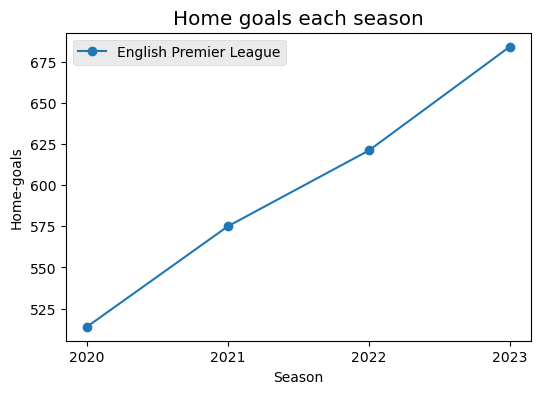

In [16]:
home_goals_per_season = df.groupby('Season')['G Home'].sum()

# Define the range of seasons
seasons = list(range(home_goals_per_season.index.min(), home_goals_per_season.index.max() + 1))

# Plotting
fig = plt.figure(figsize=(6, 4))
plt.xticks(seasons)  # Setting x-ticks to be the seasons
plt.style.use('ggplot')
plt.title('Home goals each season')
plt.xlabel('Season')
plt.ylabel('Home-goals')
plt.plot(home_goals_per_season.index, home_goals_per_season.values, label="English Premier League", marker='o')
plt.legend()
plt.show()

 ### Total number of goals scored in Home matches

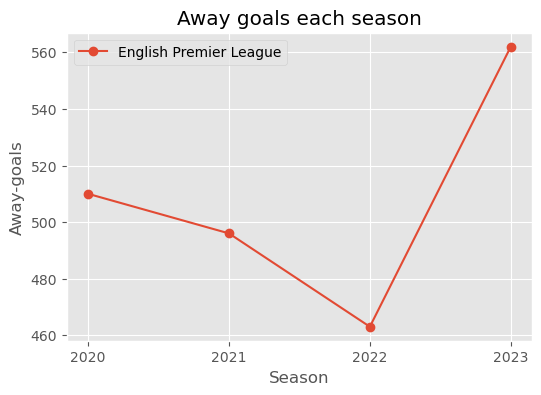

In [19]:
away_goals_per_season = df.groupby('Season')['G Away'].sum()

# Plotting
fig = plt.figure(figsize=(6, 4))  # Adjusted the figure size for better readability
plt.xticks(seasons)  # Setting x-ticks to be the seasons
plt.style.use('ggplot')
plt.title('Away goals each season')
plt.xlabel('Season')
plt.ylabel('Away-goals')
plt.plot(away_goals_per_season.index, away_goals_per_season.values, label="English Premier League", marker='o')
plt.legend()
plt.show()

### Top Goal Scoring Team at Home 


In [22]:
#Merging Home team and matches
matches_h_teams = df[['Home','G Home']]
matches_h_teams.head()

,Home,G Home
380,Fulham,0
381,Crystal Palace,1
382,Liverpool,4
383,West Ham,0
384,West Brom,0


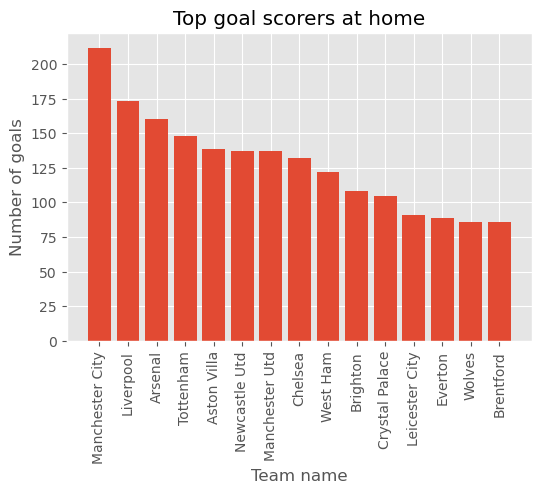

In [24]:
top_goal_scorers_home = matches_h_teams.groupby('Home')['G Home'].sum().sort_values(ascending=False)
top_goal_scorers_home.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_home.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_home.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at home")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")
plt.show()

### Top Goal Scoring Team at Away 


In [27]:
#Merging Home team and matches
matches_a_teams = df[['Away','G Away']]
matches_a_teams.head()

,Away,G Away
380,Arsenal,3
381,Southampton,0
382,Leeds United,3
383,Newcastle Utd,2
384,Leicester City,3


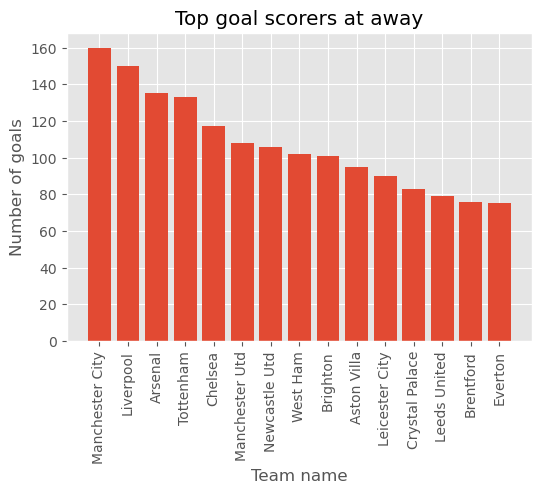

In [29]:
top_goal_scorers_away = matches_a_teams.groupby('Away')['G Away'].sum().sort_values(ascending=False)
top_goal_scorers_away.head(15)
%matplotlib inline 
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1,1,1)
rects = ax.bar(range(15), top_goal_scorers_away.head(15).values,align = "center")
ax.set_xticks(range(15))
ax.set_xticklabels(top_goal_scorers_away.head(15).index,rotation = "vertical")
ax.set_title("Top goal scorers at away")
ax.set_ylabel("Number of goals")
ax.set_xlabel("Team name")
plt.show()

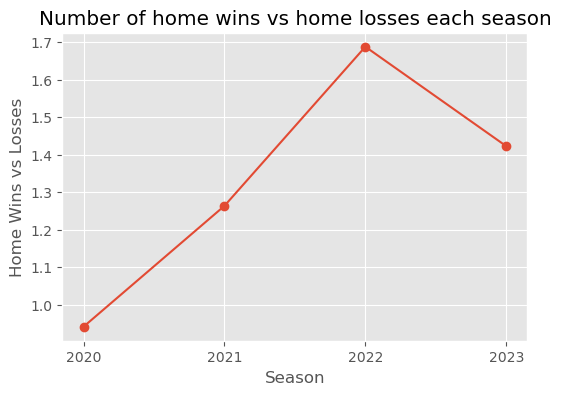

In [31]:
home_wins = df[(df.Score == 1)].groupby('Season').Score.sum()
home_losses = df[(df.Score == -1)].groupby('Season').Score.sum()

# Ensure both Series have the same index
home_wins, home_losses = home_wins.align(home_losses, join='inner')

# Calculating the ratio of home wins to home losses
e_hw = np.true_divide(home_wins.values, home_losses.values * -1)

# Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(6, 4))
plt.xticks(seasons)
plt.style.use('ggplot')
plt.title("Number of home wins vs home losses each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs Losses")
plt.plot(seasons, e_hw, marker='o')
plt.show()

### Encoding the data


In [34]:
encoded_df = df.copy()
for column in encoded_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    encoded_df[column] = le.fit_transform(df[column])

# A sample of the encoded data frame
encoded_df


,Game ID,Wk,Day,Date,Time,Home,xG Home,G Home,Away,xG Away,...,Away Avg Goals For,Home Avg Goals Against,Away Avg Goals Against,Home Matches Played,Away Matches Played,Home Points/Match,Away Points/Match,Home Cumulative Points,Away Cumulative Points,Season
380,0,1,2,2020-09-12,1,9,0.1,0,0,1.9,...,1.47,0.00,1.26,0,38,0.00,1.47,0,56,2020
381,1,1,2,2020-09-12,7,7,1.1,1,20,0.9,...,1.34,1.32,1.58,38,38,1.13,1.37,43,52,2020
382,2,1,2,2020-09-12,13,12,2.7,4,10,0.3,...,0.00,0.87,0.00,38,0,2.61,0.00,99,0,2020
383,3,1,2,2020-09-12,20,24,1.0,0,16,1.6,...,1.00,1.63,1.53,38,38,1.03,1.16,39,44,2020
384,4,1,3,2020-09-13,4,23,0.4,0,11,2.8,...,1.76,0.00,1.08,0,38,0.00,1.63,0,62,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,418,38,3,2024-05-19,10,3,1.1,2,16,3.4,...,2.24,1.48,1.50,113,189,1.27,1.41,144,266,2023
1896,419,38,3,2024-05-19,10,6,1.1,2,2,2.2,...,1.32,1.68,1.70,189,113,1.65,1.07,311,121,2023
1897,420,38,3,2024-05-19,10,7,2.5,5,1,0.9,...,1.92,1.50,1.28,189,189,1.20,1.40,226,264,2023
1898,421,38,3,2024-05-19,10,12,4.5,2,25,0.5,...,1.26,1.20,1.72,189,189,2.15,1.28,406,242,2023


### Correlation matrix

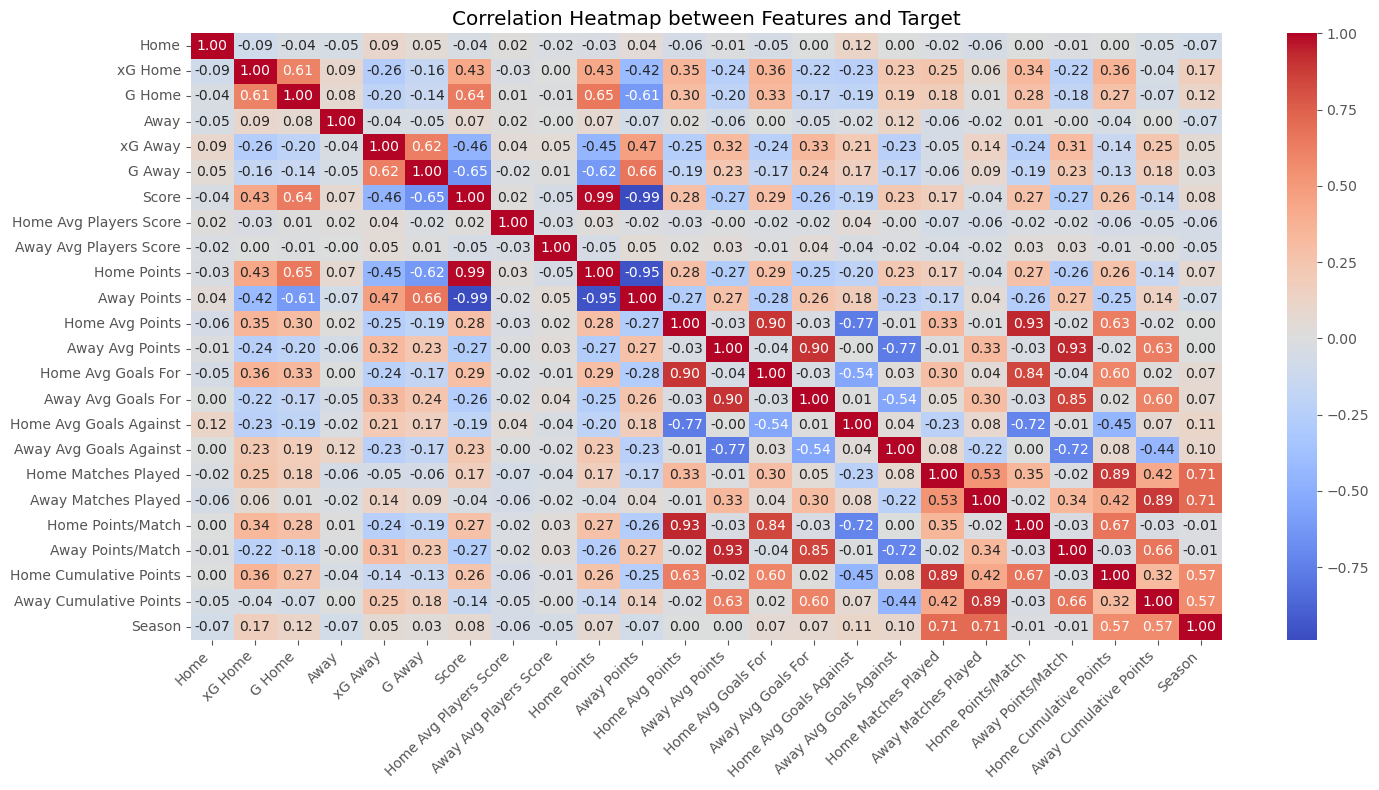

In [37]:
selected_features_with_target = encoded_df.drop(['Date','Game ID','Wk','Day','Time'],axis=1)

# Calculate the correlation matrix
correlation_matrix = selected_features_with_target.corr()

# Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})
plt.title('Correlation Heatmap between Features and Target')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Rotate y-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()

## Naive models

We will develop three simple models to serve as benchmarks for comparison with our machine learning models.

The first model will predict the score based solely on the xg parameter.
The second model will predict the score using the average player score.
The third model will combine both the xg parameter and the average player score to make its predictions. 

In [92]:
naive_models = encoded_df.copy()
xg_diff = encoded_df['xG Home'] - encoded_df['xG Away']
naive_models['xg results'] = xg_diff.apply(lambda x: 1 if x > 0.4 else (0 if x > -0.4 else -1))

avg_player_score_diff = encoded_df['Home Avg Players Score'] - encoded_df['Away Avg Players Score']
naive_models['avg player results'] = avg_player_score_diff.apply(lambda x: 1 if x > 3 else (0 if x > -3 else -1))


def combine_results(row):
    combined = row['xg results'] + row['avg player results']
    if combined > 0:
        return 1
    elif combined < 0:
        return -1
    else:
        return 0

def eli_results(row):
    if round(row['xG Home']) > round(row['xG Away']):
        return 1
    elif round(row['xG Home']) < round(row['xG Away']):
        return -1
    else:
        return 0

naive_models['combine results'] = naive_models.apply(combine_results, axis=1)
naive_models['eli results'] = naive_models.apply(eli_results, axis=1)
naive_models[['Score', 'combine results','avg player results', 'xg results', 'eli results']]

,Score,combine results,avg player results,xg results,eli results
380,-1,-1,-1,-1,-1
381,1,0,0,0,0
382,1,1,1,1,1
383,-1,0,1,-1,-1
384,-1,-1,-1,-1,-1
...,...,...,...,...,...
1895,-1,-1,-1,-1,-1
1896,1,-1,0,-1,-1
1897,1,1,0,1,1
1898,1,1,0,1,1


In [94]:
print(f"xg results {accuracy_score(naive_models['Score'],naive_models['xg results'])}")
print(f"avg player results {accuracy_score(naive_models['Score'],naive_models['avg player results'])}")
print(f"combine results {accuracy_score(naive_models['Score'],naive_models['combine results'])}")
print(f"eli results {accuracy_score(naive_models['Score'],naive_models['eli results'])}")

xg results 0.5730263157894737
avg player results 0.3256578947368421
combine results 0.5052631578947369
eli results 0.5677631578947369


In each model we will debelop our goal will be to beat the 0.5684210526315789 score!!

## Normalize the data
The score of the players need to be normalized

In [94]:
scaler = MinMaxScaler()

# Select the columns to normalize
columns_to_normalize = ['Away Avg Players Score', 'Home Avg Players Score']

# Fit and transform the selected columns
encoded_df[columns_to_normalize] = scaler.fit_transform(encoded_df[columns_to_normalize])
encoded_df

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(encoded_df.head())

     Game ID  Wk  Day       Date  Time  Home  xG Home  G Home  Away  xG Away  \
380        0   1    2 2020-09-12     1     9      0.1       0     0      1.9   
381        1   1    2 2020-09-12     7     7      1.1       1    20      0.9   
382        2   1    2 2020-09-12    13    12      2.7       4    10      0.3   
383        3   1    2 2020-09-12    20    24      1.0       0    16      1.6   
384        4   1    3 2020-09-13     4    23      0.4       0    11      2.8   

     G Away  Score  Home Avg Players Score  Away Avg Players Score  \
380       3     -1                0.122889                0.542823   
381       0      1                0.355271                0.344391   
382       3      1                0.763541                0.340169   
383       2     -1                0.517764                0.314234   
384       3     -1                0.139196                0.630881   

     Home Points  Away Points  Home Avg Points  Away Avg Points  \
380            0            3  

## Split to train test and validation
we will use one season for the validation and one for the test and the rest for the train

In [99]:
target =  df[['Score']]
#you might want to drop also 'Away Matches Played','Home Matches Played' for decrease repeatingencoded_features = encoded_df.drop(['Game ID', 'Wk', 'Day', 'Date','Time','Score','G Home','Home Points', 'Away Points','G Away'], axis =1)
encoded_features = encoded_df.drop(['Game ID', 'Wk', 'Day', 'Date','Time','Score','G Home','Home Points', 'Away Points','G Away'], axis =1)
first_year = 2019
last_year =2024
# encoded_features['Season'] -= first_year

X_train = encoded_features[encoded_features['Season'] <=  last_year-3]
X_val = encoded_features[encoded_features['Season'] ==  last_year-2]
X_test = encoded_features[encoded_features['Season'] == last_year-1]

y_train = df[df['Season'] <= last_year-3]['Score']
y_val =  df[df['Season'] == last_year-2]['Score']
y_test = df[df['Season'] ==  last_year-1]['Score']

print("Number of training dataset: ", len(X_train))
print("Number of Validation dataset: ", len(X_val))
print("Number of test dataset: ", len(X_test))
print("Total number of dataset: ", len(X_train)+len(X_test)+len(X_val))

X_train

Number of training dataset:  760
Number of Validation dataset:  380
Number of test dataset:  380
Total number of dataset:  1520


,Home,xG Home,Away,xG Away,Home Avg Players Score,Away Avg Players Score,Home Avg Points,Away Avg Points,Home Avg Goals For,Away Avg Goals For,Home Avg Goals Against,Away Avg Goals Against,Home Matches Played,Away Matches Played,Home Points/Match,Away Points/Match,Home Cumulative Points,Away Cumulative Points,Season
380,9,0.1,0,1.9,0.122889,0.542823,0.00,1.47,0.00,1.47,0.00,1.26,0,38,0.00,1.47,0,56,2020
381,7,1.1,20,0.9,0.355271,0.344391,1.13,1.37,0.82,1.34,1.32,1.58,38,38,1.13,1.37,43,52,2020
382,12,2.7,10,0.3,0.763541,0.340169,2.61,0.00,2.24,0.00,0.87,0.00,38,0,2.61,0.00,99,0,2020
383,24,1.0,16,1.6,0.517764,0.314234,1.03,1.16,1.29,1.00,1.63,1.53,38,38,1.03,1.16,39,44,2020
384,23,0.4,11,2.8,0.139196,0.630881,0.00,1.63,0.00,1.76,0.00,1.08,0,38,0.00,1.63,0,62,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,17,0.5,21,3.4,0.394875,0.547045,0.50,1.82,0.50,1.82,2.14,1.16,75,113,0.57,1.67,43,189,2021
1136,14,3.4,1,0.2,0.422248,0.331725,2.34,1.22,2.58,1.34,0.82,1.40,113,113,2.27,1.19,257,135,2021
1137,12,2.7,25,1.3,0.634246,0.482509,2.36,1.26,2.28,0.94,0.66,1.20,113,113,2.27,1.37,257,155,2021
1138,5,1.6,16,1.8,0.527082,0.265380,0.92,1.32,0.96,1.24,1.52,1.60,113,113,1.13,1.19,128,135,2021


In [103]:
def plot_confusion_matrix(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred )
    # Create a heatmap of the confusion matrixt
    plt.figure(figsize=(4, 2))
    labels = ['Win','Tie','Loss']
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix')
    plt.tight_layout()
    plt.show()

In [105]:
model_accuracies = []
models = []

In [107]:
class BaseModel:
    def __init__(self, classifier , name):
        self.model = classifier   # Initialize the model attribute, which will hold the trained model
        self.name = name
        self.roc_auc_value = 0
        self.roc_curve = []

    # The function train the model and return the time of training the model if Time is True.
    def train(self, X_train, y_train, Time = False):
        self.model.fit(X_train, y_train)

    def test(self, X_test, test = y_test):
        y_pred = self.model.predict(X_test)
        return {metric: score(test, y_pred) for metric, score in [('accuracy', accuracy_score),
                                    ('precision', precision_score), ('recall', recall_score), ('f1_score', f1_score)]}

    def evaluate_with_cross_validation(self, X, y, scoring='accuracy', cv=5):
        """
        Evaluate the model using k-fold cross-validation.

        Parameters:
        - X: Input features.
        - y: Target labels.
        - scoring: The scoring metric to use (e.g., 'accuracy', 'precision', 'recall', 'f1').
        - cv: Number of cross-validation folds.

        Returns:
        - scores: List of cross-validation scores.
        """
        scores = cross_val_score(self.model, X, y, cv=cv, scoring=scoring)
        return scores
    
    def tune_hyperparameters(self, hyperparameter_grid, X ,y, scoring = "accuracy", cv=5,verbose = 1):
        grid_search = GridSearchCV(estimator=self.model, param_grid=hyperparameter_grid,
                                   return_train_score=True, cv=cv, scoring=scoring, verbose  = verbose, error_score= 'raise')
        grid_search.fit(X, y)
        self.model = grid_search.best_estimator_
        return grid_search.cv_results_['mean_test_score'] # return the mean test of the grid search
    
    def tune_hyperparameters_with_validation_set(self,model_class ,hyperparameter_grid, X_train, y_train, X_val, y_val):
        """
        function for hyperparameter tuning using a validation set.

        Parameters:
        - model_class: The classifier class (e.g., KNeighborsClassifier).
        - param_grid: The dictionary of hyperparameters to tune.
        - X_train: Training feature set.
        - y_train: Training target set.
        - X_val: Validation feature set.
        - y_val: Validation target set.

        Returns:
        - best_score: The validation score of the best model.
        """
        best_score = 0
        best_params = None
        best_model = None

        for params in ParameterGrid(hyperparameter_grid):
            curr_model = model_class(**params)
            curr_model.fit(X_train, y_train)
            y_val_pred = curr_model.predict(X_val)
            val_score = accuracy_score(y_val, y_val_pred)
            if val_score > best_score:
                best_score = val_score
                best_params = params
                best_model = curr_model
        self.model = best_model
        return best_score

## One-vs-Rest (OvR) Logistic Regression

In [138]:
ovr_LR= BaseModel(classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear',class_weight='balanced')) ,name= "One-vs-Rest (OvR) Logistic Regression")
ovr_LR.train(X_train,y_train)
cross_val_scores = ovr_LR.evaluate_with_cross_validation(X_val, y_val, scoring='accuracy')

print(f'Mean CV accuracy for {ovr_LR.name}:  {np.mean(cross_val_scores)}')
y_pred = ovr_LR.model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"confusion matrix for {ovr_LR.name}: \n {conf_matrix}")

if ovr_LR not in models:
    model_accuracies.append(accuracy_score(y_test, y_pred))
    models.append(ovr_LR)

print(f"accuracy =  {accuracy_score(y_test, y_pred):.5f}")


Mean CV accuracy for One-vs-Rest (OvR) Logistic Regression:  0.5605263157894737
confusion matrix for One-vs-Rest (OvR) Logistic Regression: 
 [[ 65  28  30]
 [ 19  20  43]
 [ 15  27 133]]
accuracy =  0.57368


## SVM

In [140]:
%%time
# Define a dictionary of hyperparameters and their possible values
param_grid_SVM = {
    'kernel': ['linear'],
    'C': [0.01,0.1],
    'gamma': [0.1, 1, 'scale'],
}

svm = BaseModel(SVC(probability=True, random_state=42,class_weight='balanced'), "SVM")
best_score = svm.tune_hyperparameters_with_validation_set(SVC,param_grid_SVM,X_train, y_train, X_val, y_val)
svm.train(X_train, y_train)
SVM= svm

CPU times: total: 1.12 s
Wall time: 2.35 s


In [142]:
print(f"{SVM.name}: C: {SVM.model.C} , k: {SVM.model.kernel} , g: {SVM.model.gamma},\nAccuracy validation score {best_score:.5f}")
y_pred = SVM.model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix for {SVM.name}: \n {conf_matrix}")
accuracy = accuracy_score(y_test, y_pred)
if SVM not in models:
    model_accuracies.append(accuracy)
    models.append(SVM)
print(f"accuracy =  {accuracy:.5f}")

SVM: C: 0.01 , k: linear , g: 0.1,
Accuracy validation score 0.55789
confusion matrix for SVM: 
 [[ 80   0  43]
 [ 26   0  56]
 [ 18   1 156]]
accuracy =  0.62105


## KNN

In [116]:
maxK = 200
accuracies_KNN = []
knn = BaseModel(KNeighborsClassifier(), "KNN")
knn_grid = {'n_neighbors': range(1, maxK+1,2), 'metric': ['euclidean', 'manhattan']}
accuracies_KNN =  knn.tune_hyperparameters_with_validation_set(KNeighborsClassifier,knn_grid,X_train, y_train, X_val, y_val)
knn.train(X_train,y_train)
KNN = knn


KeyboardInterrupt: 

In [122]:
plt.figure(figsize=(10, 6))
euclidean_scores = []
manhattan_scores = []
neighbors = list(range(1, maxK + 1,2))

for i in neighbors:
    euclidean_knn = KNeighborsClassifier(n_neighbors=i, metric='euclidean')
    manhattan_knn = KNeighborsClassifier(n_neighbors=i, metric='manhattan')
    
    euclidean_knn.fit(X_train, y_train)
    euclidean_score = euclidean_knn.score(X_val, y_val)
    euclidean_scores.append(euclidean_score)
    
    manhattan_knn.fit(X_train, y_train)
    manhattan_score = manhattan_knn.score(X_val, y_val)
    manhattan_scores.append(manhattan_score)

plt.plot(neighbors, euclidean_scores, marker='o', label='Euclidean')
plt.plot(neighbors, manhattan_scores, marker='o', label='Manhattan')

plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Performance with Different Metrics')
plt.legend()

plt.show()


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [ ]:
print(f'Best Accuracy on cross validation with KNN (k = {KNN.model.n_neighbors}) (Metric = {KNN.model.metric}) {(accuracies_KNN)}')
y_pred = KNN.model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"confusion matrix for KNN: \n {conf_matrix}")
accuracy = accuracy_score(y_test, y_pred)
if KNN not in models:
    model_accuracies.append(accuracy)
    models.append(KNN)
print(f"accuracy =  {accuracy:.5f}")


## Decision tree

In [124]:
DT= BaseModel(classifier = DecisionTreeClassifier() ,name= "Descion Tree")
DT.train(X_train,y_train)
cross_val_scores = DT.evaluate_with_cross_validation(X_val, y_val, scoring='accuracy')
print(f'Mean CV accuracy for {DT.name}:  {np.mean(cross_val_scores)}')

y_pred = DT.model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix for Descion Trees with {DT.name}: \n {conf_matrix}")
accuracy = accuracy_score(y_test, y_pred)
model_accuracies.append(accuracy)
models.append(DT)
print(f"accuracy =  {accuracy:.5f}")


Mean CV accuracy for Descion Tree:  0.43157894736842106
confusion matrix for Descion Trees with Descion Tree: 
 [[ 68  25  30]
 [ 20  18  44]
 [ 34  31 110]]
accuracy =  0.51579


## Random Forest

Fitting 5 folds for each of 15 candidates, totalling 75 fits


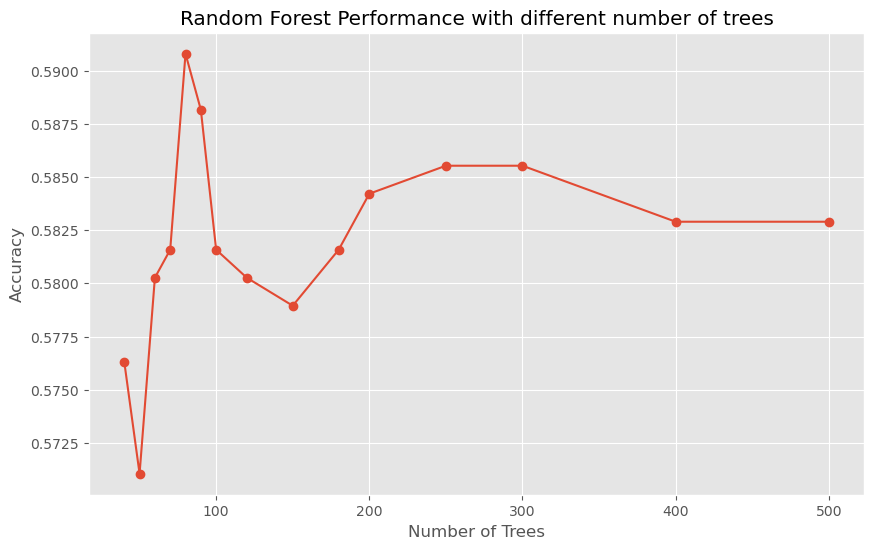

In [126]:

param_grid_RF = {
    'n_estimators': [40,50,60,70,80,90,100,120,150,180,200,250,300,400,500],
}

rf = BaseModel(RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42), "Random Forest")
accuracies_RF = (rf.tune_hyperparameters(param_grid_RF ,X_train,y_train))

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(param_grid_RF.get('n_estimators'), accuracies_RF,marker = 'o')

plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance with different number of trees')
plt.show()


In [127]:
%%time
new_param_grid_RF = {
    'n_estimators': [50,60,70,80,90,100,120,150],
    'max_features' : [None,'sqrt',7,0.5,0.1],
    'min_samples_leaf' : [10,15,20,25,30,40]
}


rf = BaseModel(RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42,class_weight='balanced' ), "Random Forest")
new_accuracies_RF = rf.tune_hyperparameters_with_validation_set(RandomForestClassifier,new_param_grid_RF
                                                                ,X_train, y_train, X_val, y_val)
RF = rf
RF_curr = RF.model


CPU times: total: 46.6 s
Wall time: 1min 40s


In [128]:
print(f'{RF.name} \nn_estimators: {RF_curr.n_estimators}, max_features: {RF_curr.max_features}, min_samples_leaf: {RF_curr.min_samples_leaf} with validation accuracy : {new_accuracies_RF}' )


Random Forest 
n_estimators: 120, max_features: 7, min_samples_leaf: 10 with validation accuracy : 0.5868421052631579


In [129]:
RF.model.score(X_test,y_test)

0.6157894736842106

In [33]:
# test
y_pred = RF.model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"confusion matrix for Random forest  \n {conf_matrix}")
acc_test_RF = (accuracy_score(y_test, y_pred))
model_accuracies.append(accuracy)
models.append(RF)
print(f"accuracy =  {acc_test_RF:.5f}")

confusion matrix for Random forest  
 [[ 85   6  32]
 [ 31   9  42]
 [ 35   8 132]]
accuracy =  0.59474


## XGBoost

In [134]:
%%time

# Define hyperparameters grid for XGBoost
param_grid_XGB = {
    'n_estimators': [60,80,100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}
# Hyperparameter tuning and evaluation for XGBoost
xgb = BaseModel(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), "XGBoost")
best_score = xgb.tune_hyperparameters_with_validation_set(XGBClassifier,param_grid_XGB,X_train, y_train+1, X_val, y_val+1)
XGB = xgb
XGB_curr = XGB.model

CPU times: total: 3min
Wall time: 52.2 s


In [135]:
print(f'{XGB.name} \n n_estimators: {XGB_curr.n_estimators}, max_depth: {XGB_curr.max_depth}, learning_rate: {XGB_curr.learning_rate}, subsample: {XGB_curr.subsample}, colsample_bytree: {XGB_curr.colsample_bytree} with validation accuracy : {best_score:.5f}')

# Test the best model
y_pred = XGB.model.predict(X_test)
conf_matrix = confusion_matrix(y_test+1, y_pred)
print(f"Confusion matrix for {XGB.name} \n {conf_matrix}")
accuracy = accuracy_score(y_test+1, y_pred)
if XGB not in models:
    model_accuracies.append(accuracy)
    models.append(XGB)
print(f"Accuracy = {accuracy:.5f}")

XGBoost 
 n_estimators: 100, max_depth: 3, learning_rate: 0.05, subsample: 0.8, colsample_bytree: 0.7 with validation accuracy : 0.57105
Confusion matrix for XGBoost 
 [[ 80  10  33]
 [ 26   8  48]
 [ 22   7 146]]
Accuracy = 0.61579


## Model selection

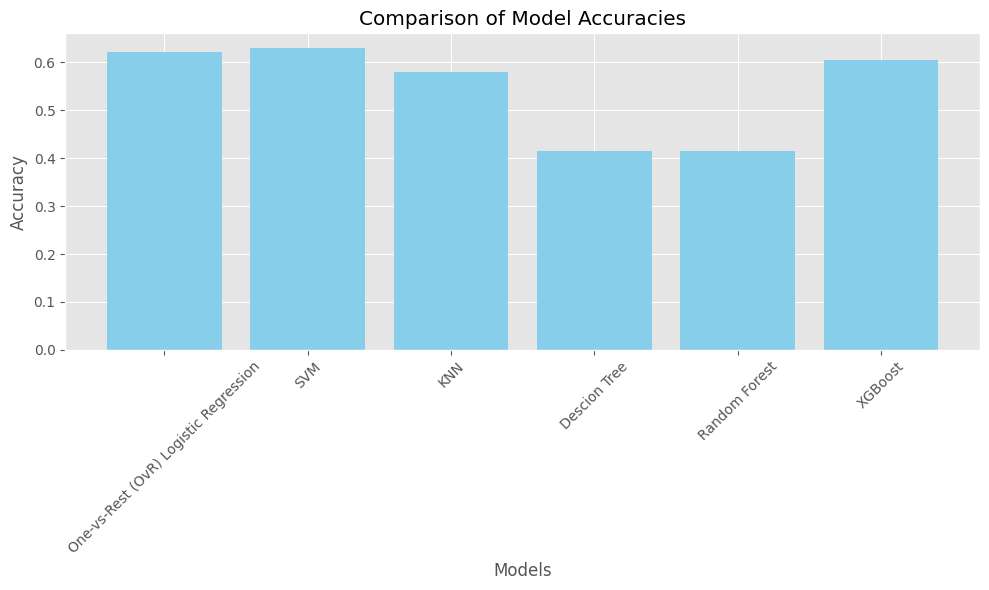

In [36]:
model_names = [model.name for model in models]

plt.figure(figsize=(10, 6))
plt.bar(model_names, model_accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)  
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## LSTM (Time Series)

In [37]:
df

,Game ID,Wk,Day,Date,Time,Home,xG Home,G Home,Away,xG Away,...,Away Avg Goals For,Home Avg Goals Against,Away Avg Goals Against,Home Matches Played,Away Matches Played,Home Points/Match,Away Points/Match,Home Cumulative Points,Away Cumulative Points,Season
0,0,1,Fri,2019-08-09,20:00,Liverpool,1.8,4,Norwich City,0.9,...,0.00,0.00,0.00,0,0,0.00,0.00,0,0,2019
1,1,1,Sat,2019-08-10,12:30,West Ham,1.1,0,Manchester City,3.2,...,0.00,0.00,0.00,0,0,0.00,0.00,0,0,2019
2,2,1,Sat,2019-08-10,15:00,Burnley,0.9,3,Southampton,1.2,...,0.00,0.00,0.00,0,0,0.00,0.00,0,0,2019
3,3,1,Sat,2019-08-10,15:00,Watford,0.7,0,Brighton,0.8,...,0.00,0.00,0.00,0,0,0.00,0.00,0,0,2019
4,4,1,Sat,2019-08-10,15:00,Crystal Palace,0.9,0,Everton,1.1,...,0.00,0.00,0.00,0,0,0.00,0.00,0,0,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,418,38,Sun,2024-05-19,16:00,Brentford,1.1,2,Newcastle Utd,3.4,...,2.24,1.48,1.50,113,189,1.27,1.41,144,266,2023
1896,419,38,Sun,2024-05-19,16:00,Chelsea,1.1,2,Bournemouth,2.2,...,1.32,1.68,1.70,189,113,1.65,1.07,311,121,2023
1897,420,38,Sun,2024-05-19,16:00,Crystal Palace,2.5,5,Aston Villa,0.9,...,1.92,1.50,1.28,189,189,1.20,1.40,226,264,2023
1898,421,38,Sun,2024-05-19,16:00,Liverpool,4.5,2,Wolves,0.5,...,1.26,1.20,1.72,189,189,2.15,1.28,406,242,2023


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization , Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


# Assuming df contains your dataset with game data for multiple teams
sequence_length = 10

X, y =  [], []


lstm_df = encoded_df.copy()

lstm_df = lstm_df.drop(['Game ID', 'Wk', 'Day','Time','Home Points', 'Away Points'], axis =1)
lstm_df['Date'] = pd.to_datetime(lstm_df['Date'],dayfirst=True)

home_features = [c  for c in lstm_df.columns if 'Home' in c]
away_features =  [c  for c in lstm_df.columns if 'Away' in c]
teams = encoded_df['Home'].unique()  # Get unique team names

for team in teams:
    team_games = encoded_df[(encoded_df['Home'] == team) | (encoded_df['Away'] == team)].sort_values(by='Date') # Get games for the current team
    for i in range(len(team_games) - sequence_length):
        sequence_data = []
        for j in range(sequence_length):
            game = team_games.iloc[i+j]
            score = game['Score']
            if game['Home'] == team:
                features = game[home_features].values
            else:
                score = -game['Score']
                features = game[away_features].values
                
            # Append the modified score to the feature set
            features_with_score = np.append(features, score)
            sequence_data.append(features_with_score)
        X.append(sequence_data)
        
        # Adjust the score depend if the current team is home or away 
        target_game = team_games.iloc[i+sequence_length]
        score = target_game['Score']
        if team == target_game['Away']:
            score = -score
        y.append(score)


In [39]:
print(y[0])
X[0]

1


[array([12, 1.8, 4, 0.8421665695981355, 0.0, 0.0, 0.0, 0, 0.0, 0, 1],
       dtype=object),
 array([12, 1.3, 2, 0.3325554259043173, 3.0, 4.0, 1.0, 1, 3.0, 3, 1],
       dtype=object),
 array([12, 2.5, 3, 0.439138031450204, 3.0, 3.0, 1.0, 2, 3.0, 6, 1],
       dtype=object),
 array([12, 1.0, 3, 0.4200700116686118, 3.0, 3.0, 1.0, 3, 3.0, 9, 1],
       dtype=object),
 array([12, 3.0, 3, 0.5468841001747231, 3.0, 3.0, 0.75, 4, 3.0, 12, 1],
       dtype=object),
 array([12, 0.6, 2, 0.40081680280046683, 3.0, 3.0, 0.8, 5, 3.0, 15, 1],
       dtype=object),
 array([12, 1.9, 1, 0.499416569428238, 3.0, 2.83, 0.83, 6, 3.0, 18, 1],
       dtype=object),
 array([12, 3.5, 2, 0.5468841001747231, 3.0, 2.57, 0.71, 7, 3.0, 21, 1],
       dtype=object),
 array([12, 1.2, 1, 0.4725787631271885, 3.0, 2.5, 0.75, 8, 3.0, 24, 0],
       dtype=object),
 array([12, 2.6, 2, 0.3808969132207345, 2.78, 2.33, 0.78, 9, 2.78, 25, 1],
       dtype=object)]

So Team 12 win in her sixth game

In [40]:
X = np.array(X,dtype=np.float32)
y = np.array(y,dtype=np.float32)
label_mapping = {-1: 0, 0: 1, 1: 2}

# Map the labels to score will be beteen 0 to 2
y_mapped = np.array([label_mapping[label] for label in y])

# Reshape X to match LSTM input shape (samples, time steps, features)
X = np.reshape(X, (X.shape[0], sequence_length, len(X[0][0])))
split = int(0.8 * len(X))  # 80% training, 20% testing
X_train_lstm, X_test_lstm = X[:split], X[split:]
y_train_lstm, y_test_lstm = y_mapped[:split], y_mapped[split:]


In [41]:
X.shape

(3540, 10, 11)

### Apply LSTM on the  dataset

In [42]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(LSTM(units=25, kernel_regularizer=l2(0.01)))
model.add(Dense(25, activation='relu'))
model.add(Dense(3, activation='softmax'))  



learning_rate = 0.001 
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights = True)  # Stop training if validation loss doesn't improve for 5 epochs

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           44800     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 batch_normalization (Batch  (None, 10, 100)           400       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 10, 50)            200       
 chNormalization)                                       

In [64]:
class_weights

{0: 1051, 1: 620, 2: 1161}

In [65]:
class_weights = {
    0: (y_train_lstm == 0).sum(),  # Weight for draws
    1: (y_train_lstm == 1).sum(),  # Weight for wins
    2: (y_train_lstm == 2).sum()   # Weight for losses
}
# Training
history =model.fit(X_train_lstm, y_train_lstm, epochs=40,class_weight=class_weights, batch_size=32, validation_data=(X_test_lstm, y_test_lstm),callbacks=[early_stopping])

# Evaluation
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print("Test Accuracy:", accuracy)
print("Test loss:", loss)


Epoch 1/40
89/89 [==============================] - 2s 22ms/step - loss: 955.8266 - accuracy: 0.4809 - val_loss: 1.6118 - val_accuracy: 0.4548
Epoch 2/40
89/89 [==============================] - 3s 30ms/step - loss: 955.3540 - accuracy: 0.4820 - val_loss: 1.6278 - val_accuracy: 0.4068
Epoch 3/40
89/89 [==============================] - 3s 33ms/step - loss: 955.8421 - accuracy: 0.4781 - val_loss: 1.6603 - val_accuracy: 0.3870
Epoch 4/40
89/89 [==============================] - 2s 23ms/step - loss: 953.7646 - accuracy: 0.4689 - val_loss: 1.6680 - val_accuracy: 0.4350
Epoch 5/40
89/89 [==============================] - 2s 22ms/step - loss: 947.0917 - accuracy: 0.4876 - val_loss: 1.6783 - val_accuracy: 0.4308
Epoch 6/40
23/23 [==============================] - 0s 8ms/step - loss: 1.6118 - accuracy: 0.4548
Test Accuracy: 0.4548022747039795
Test loss: 1.611751914024353


23/23 [==============================] - 0s 8ms/step


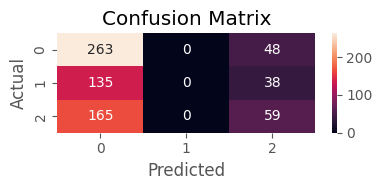

array([[0.16251786, 0.11878785, 0.7186943 ],
       [0.16250809, 0.11881328, 0.7186786 ],
       [0.16372173, 0.11872508, 0.71755314],
       ...,
       [0.67029715, 0.09086469, 0.23883815],
       [0.67054933, 0.09076636, 0.23868436],
       [0.6725724 , 0.08993071, 0.23749687]], dtype=float32)

In [66]:
pred = model.predict(X_test_lstm)
pred_class =np.argmax(pred, axis=1)
plot_confusion_matrix(y_test=y_test_lstm, y_pred= pred_class)
pred

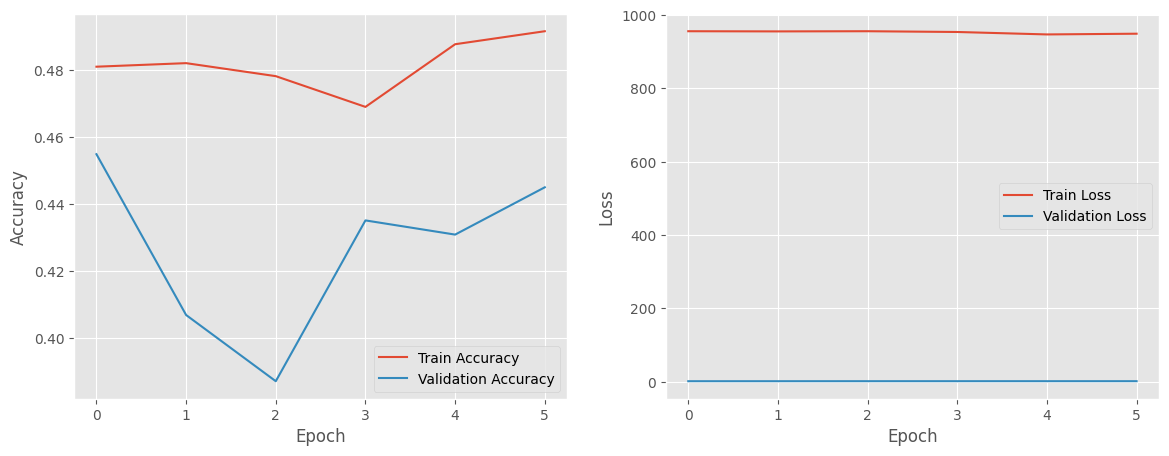

In [67]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()